<a href="https://colab.research.google.com/github/Cherrymmu/AIFFEL_Online_Quest_Cherry/blob/main/Exploration_CR7/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. 거울아 거울아, 나는 멍멍이 상이니, 아니면 냥이 상이니? [프로젝트]
---
2-1. 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기
자, 이제 여러분의 차례입니다.
지금까지 진행했던 모든 과정을 통째로 활용해서, 새로운 데이터셋에 대해 여러분의 직접 모델을 만들어 볼 것입니다.

다음에 제안된 순서는 모두 위에서 진행했던 과정의 일부입니다. 몇 가지 코드만 수정하면 성공적으로 프로젝트를 진행할 수 있을 것입니다.
진행하다가 혹시 도움이 필요하다면 위에서 진행했던 실습 코드를 다시 참고하세요! 모든 해답은 그 안에 있습니다.

그러면, 시작해볼까요!

Step 1. 데이터셋 내려받기
이번에는 tensorflow_datasets 에 포함된 tf_flowers 데이터를 사용해 보겠습니다. tf_flowers 데이터에 대한 정보는 다음에서 확인해볼 수 있습니다.
tfds.load를 활용하여 데이터셋을 다운받으세요.
https://www.tensorflow.org/datasets/catalog/tf_flowers

In [ ]:
import warnings
warnings.filterwarnings("ignore")

print("완료!")

완료!


In [ ]:
# tensorflow, tensorflow_datasets_download
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)
print(tfds.__version__)

2.15.0
4.9.4


In [ ]:
# 데이터셋 다운로드 & 압축 해제
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='tf_flowers',
                                   untar=True)

In [ ]:
# 데이터 다운받은 것을 활용해서 train, validation, test 셋으로 나누는 작업
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir=data_dir,
    download=True,
    with_info=True,
    as_supervised=True,
)

In [ ]:
# 데이터셋 확인
print(raw_train)
print(raw_validation)
print(raw_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
# 클래스의 수를 확인
num_classes = metadata.features['label'].num_classes
print("꽃의 종류 수:", num_classes)

꽃의 종류 수: 5


이미지의 크기가 전부 다르기 때문에 크기를 맞춰주는 작업을 해야겠다.

In [ ]:
# 일단 그 전에 시각화로 데이터 확인
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("힣")

힣


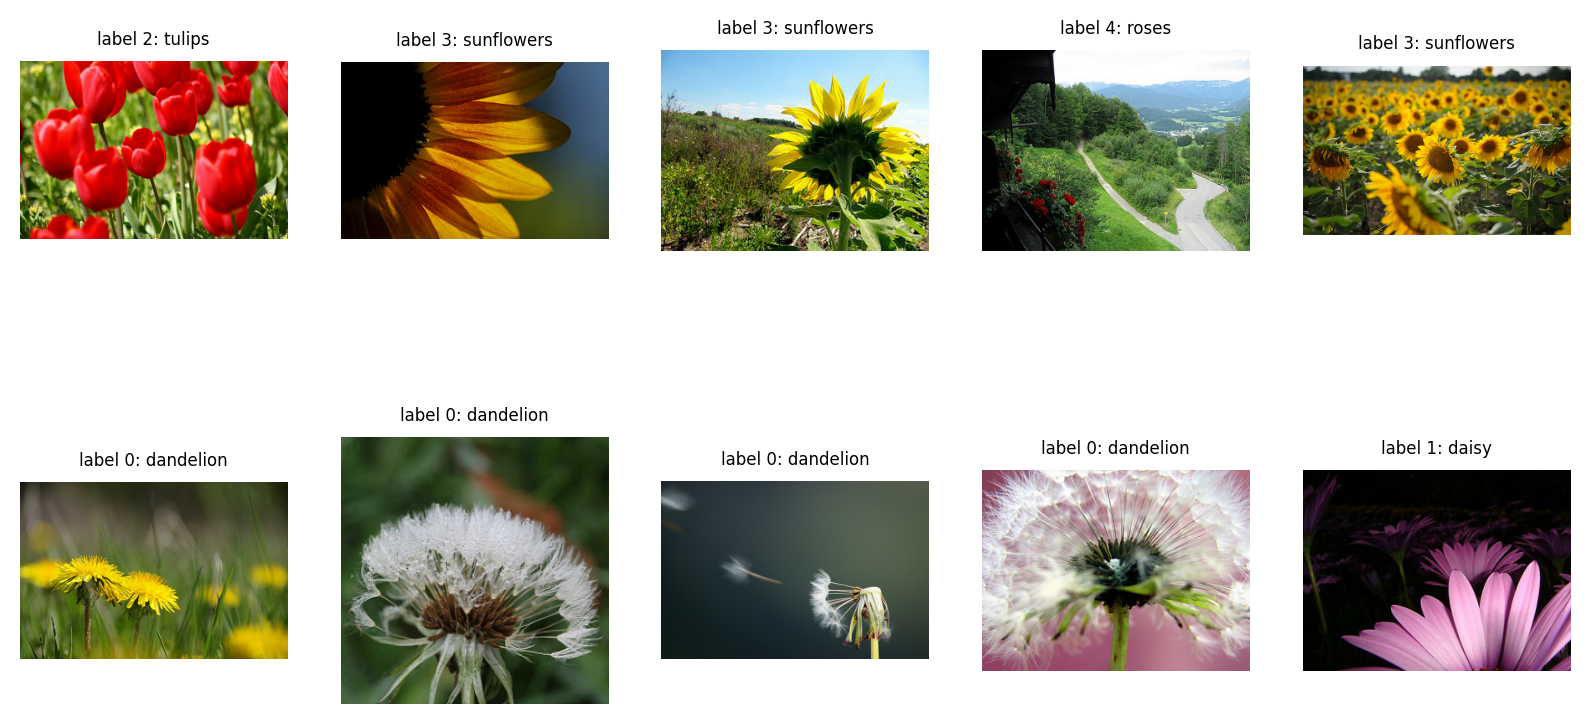

In [ ]:
# 10, 5 짜리 그래프로 확인
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)): # 10개의 데이터 가져옴
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def augment(image, label):
    image = tf.cast(image, tf.float32)  # 이미지를 float32 타입으로 캐스팅
    image = image / 255.0  # [0, 1] 범위로 정규화
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    # 기타 증강 기법을 추가할 수 있습니다.
    return image, label

# 훈련 데이터셋에 데이터 증강 적용
augmented_train = raw_train.map(augment)

# 시각화를 위한 코드
get_label_name = metadata.features['label'].int2str
plt.figure(figsize=(20, 10))  # 그래프 크기를 조정

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

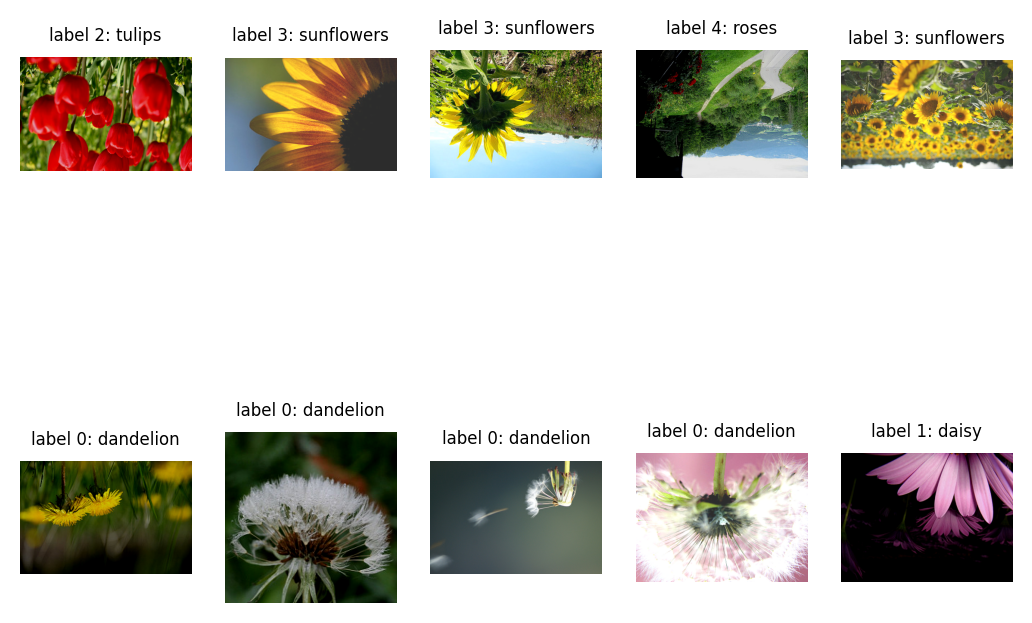

In [ ]:
# 원본 이미지 및 증강 이미지 시각화
plt.rcParams.update({'font.size': 5})  # 폰트 크기를 5으로 설정
for idx, (image, label) in enumerate(augmented_train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = tf.clip_by_value(image, 0, 1)  # 픽셀 값을 [0, 1] 범위로 클리핑
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

plt.show()

In [ ]:
# 데이터의 크기 조절을 하겠다.
IMG_SIZE = 224 #리사이징 이미지 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32) # image=float(image)같은 타입캐스팅의 텐서플로우 버전
    image = (image/255.0) # 픽셀 값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("힣")

힣


In [ ]:
# IMG_SIZE를 160으로 지정해 줌으로써, 모든 이미지의 크기를 (160, 160, 3)으로 통일
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


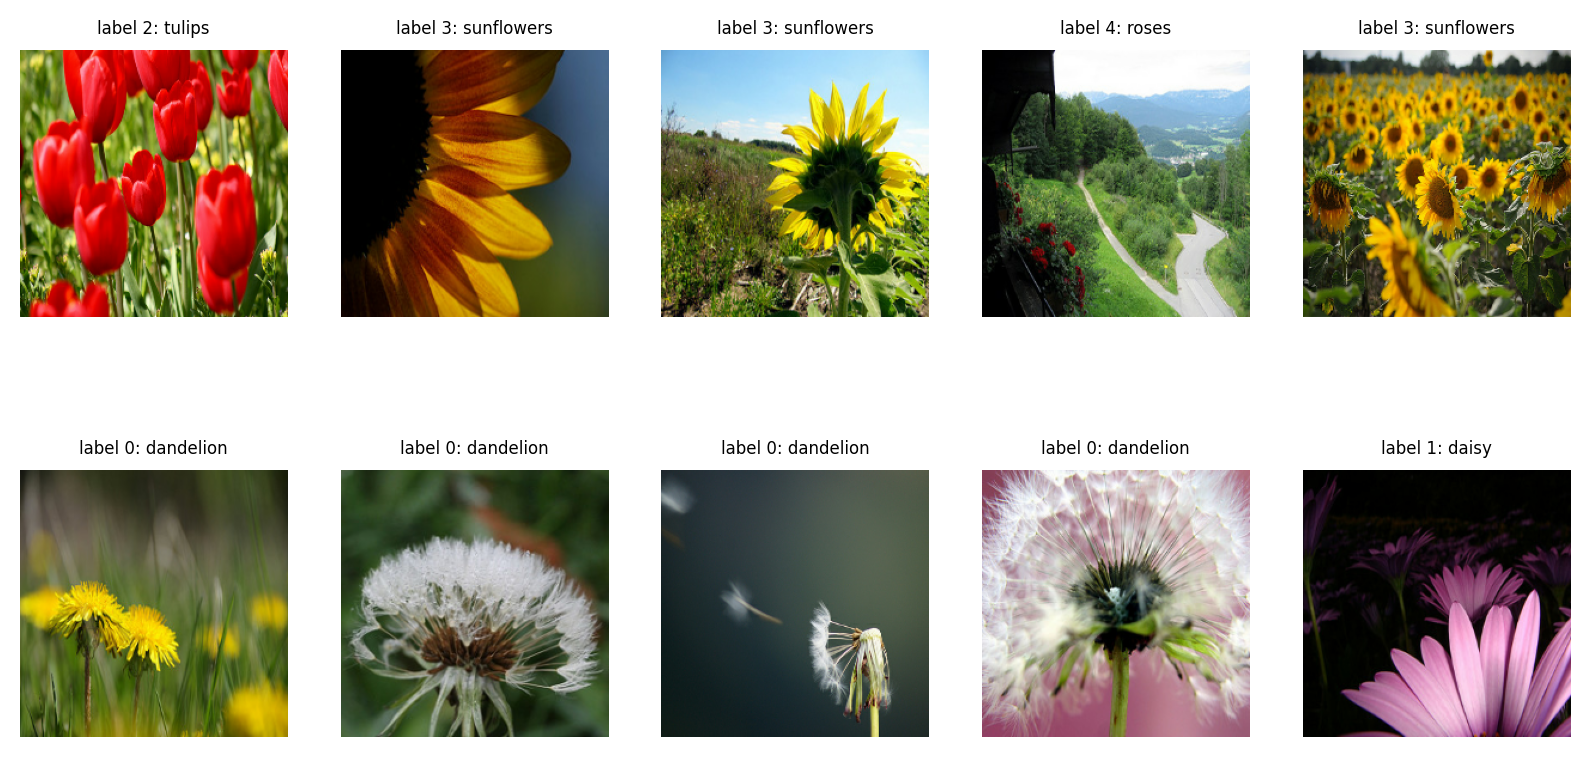

In [ ]:
# 한번 더 확인
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx,(image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = image
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')
# 다시 이미지를 시각적으로 확인해 다시 확인해 보니 모든 이미지의 크기가 균일해진 것을 확인할 수 있습니다.

나는 노드에서 진행한 것과 다르게 사이즈를 255.0 으로 맞추고 이후에 리사이징한 크기자체를 불러와서 시각화를 진행했다.

# MobileNetV2 모델 부르기
---

나는 MobileNetV2 모델을 베이스 모델로 해서 프로젝트를 완성하기 원하기 때문에 베이스 모델로 VGG16 모델을 부르겠다.


In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
#  모델 배치사이즈등을 정해준다.
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
print("힣")

힣


BATCH_SIZE에 따라 32개의 데이터를 랜덤으로 줄 train_batches, validation_batches, test_batches를 만들어 준다. train_batches는 모델이 끊임없이 학습될 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
print("힣")

힣


In [ ]:
# train 데이터에서 확인
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32]))

전처리 된 데이터셋을 불러 base_model에 넣는다.

In [ ]:
# 그전에 확인
image_batch.shape

TensorShape([32, 224, 224, 3])

In [ ]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 7, 7, 1280])

In [ ]:
# Base_model 구조 확인
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_17[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
# 글로벌 어버리지를 통해서 크기만 줄이고 그대로 남기겠다.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
print("힣")

힣


In [ ]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
# 레이어 구성후 마지막 소프트맥스의 units 값을 5로 만들어준다.

dense_layer = tf.keras.layers.Dense(
    units=512,
    activation='relu'
)

# unit은 우리가 분류하고 싶은 class는 5개였기 때문에 5로 유닛을 준다.
# 활성화 함수는 Softmax를 사용
prediction_layer = tf.keras.layers.Dense(
    units=5,
    activation='softmax'
)

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))
print(prediction_batch.shape)

(32, 5)


In [ ]:
# 사전 훈련된 모델 고정하기
base_model.trainable = False
print("힣")

힣


In [ ]:
# 최종모델
model = tf.keras.Sequential([
    base_model,             # 베이스 모델
    global_average_layer,   # 글로벌 평균 풀링 레이어
    dense_layer,            # 밀집 레이어 (ReLU 활성화)
    prediction_layer        # 예측 레이어 (Softmax 활성화)
])
print("힣")

힣


In [ ]:
# 구조 확인
model.summary()

In [ ]:
# 컴파일!
base_learning_rate = 0.0000999
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=base_learning_rate), #tf.keras.optimizers.RMSprop 문제가 mac 환경에는 있기 때문에 전 버전을 활용
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

print("힣")

In [ ]:
# 예상 해보기
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/20 [=================>............] - ETA: 0s - loss: 1.8872 - accuracy: 0.3134

20/20 [==============================] - 2s 13ms/step - loss: 1.8872 - accuracy: 0.3134
initial loss: 1.89
initial accuracy: 0.31


Epoch 1/50
92/92 [==============================] - 5s 20ms/step - loss: 0.7166 - accuracy: 0.7490 - val_loss: 0.4761 - val_accuracy: 0.8583
Epoch 2/50
92/92 [==============================] - 2s 19ms/step - loss: 0.3769 - accuracy: 0.8760 - val_loss: 0.3787 - val_accuracy: 0.8719
Epoch 3/50
92/92 [==============================] - 2s 19ms/step - loss: 0.2842 - accuracy: 0.9118 - val_loss: 0.3635 - val_accuracy: 0.8910
Epoch 4/50
92/92 [==============================] - 2s 19ms/step - loss: 0.2314 - accuracy: 0.9305 - val_loss: 0.3148 - val_accuracy: 0.9074
Epoch 5/50
92/92 [==============================] - 2s 19ms/step - loss: 0.1880 - accuracy: 0.9445 - val_loss: 0.3074 - val_accuracy: 0.9128
Epoch 6/50
92/92 [==============================] - 2s 19ms/step - loss: 0.1578 - accuracy: 0.9591 - val_loss: 0.3100 - val_accuracy: 0.9101
Epoch 7/50
92/92 [==============================] - 2s 19ms/step - loss: 0.1319 - accuracy: 0.9697 - val_loss: 0.3013 - val_accuracy: 0.9155
Epoch 8/50
92

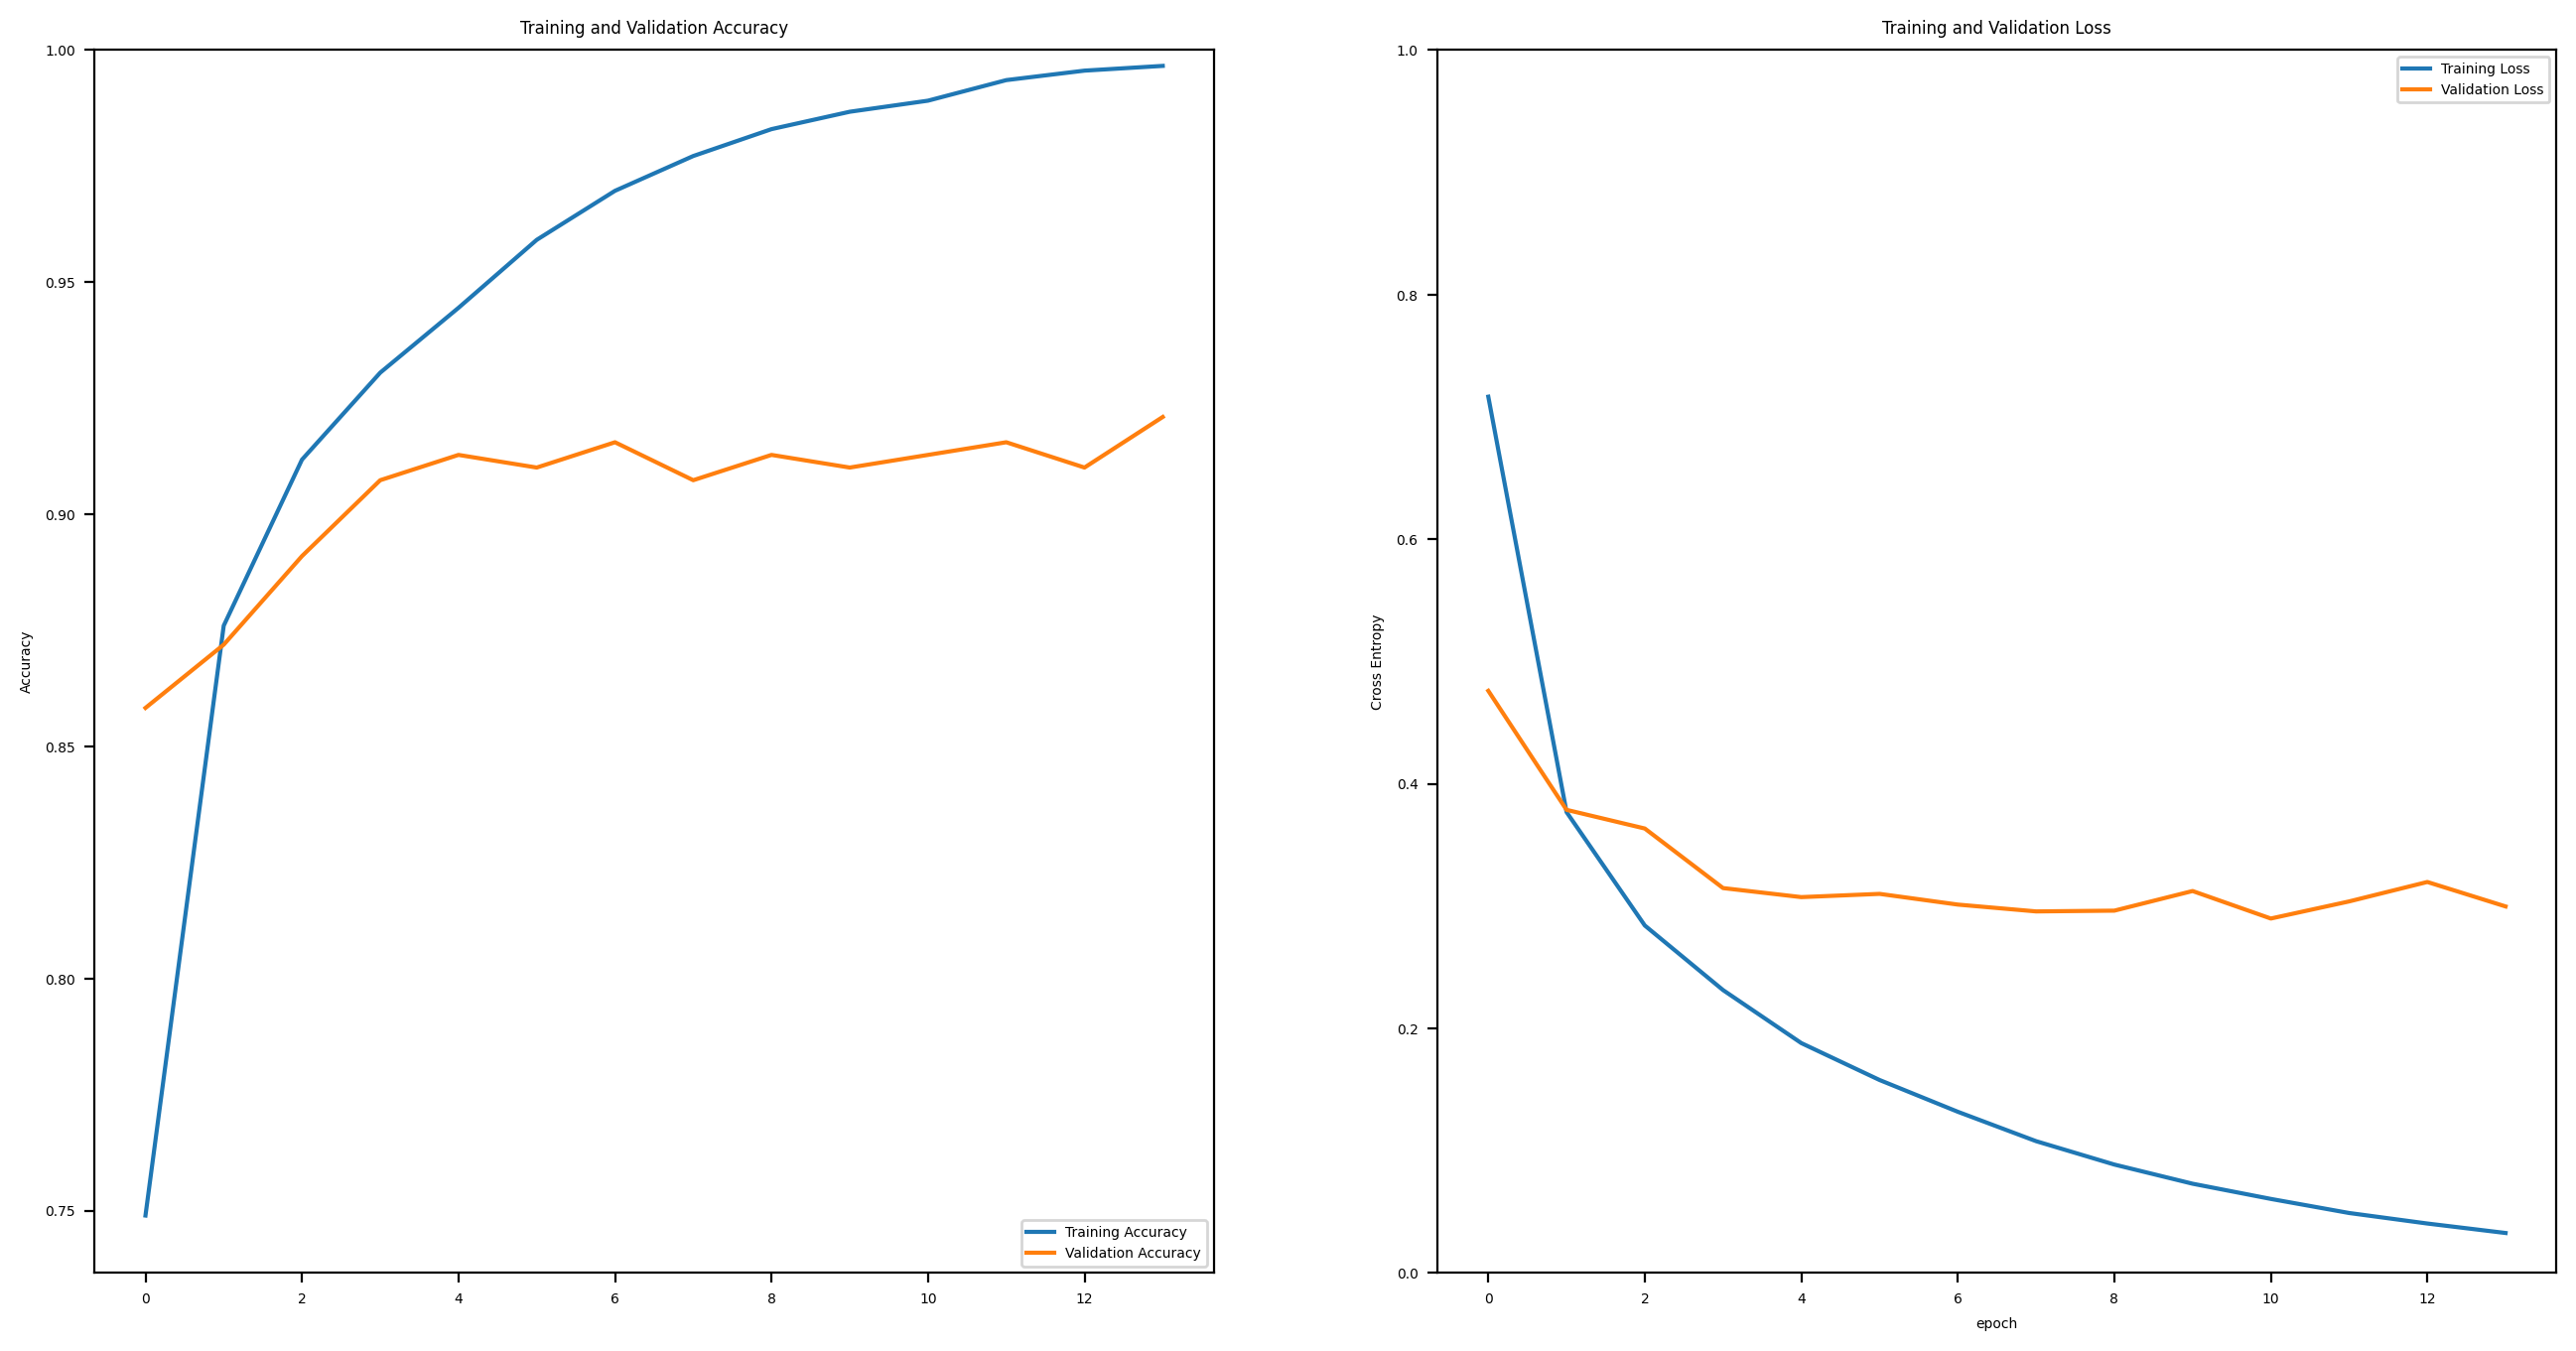

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 50 # 베이스 모델이 좋지만 위에서 로스률과 어큐러시때문에 50으로 주겠다.

# 얼리 스톱 & 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches,
    callbacks=[early_stopping]
)

# 훈련 및 검증 정확도와 손실 값 추출
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

위에서 했던 것과 같이 또 32개의 test sample에 대한 예측 결과를 눈으로도 확인해보고,
샘플을 test_batches에서 가져와 예측 결과 생성

In [ ]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

In [ ]:
# 0 과 1 사이로 확률값을 가지고 prediction 값들을 실제 추론한 라벨로 변환
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 2, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 2])

In [ ]:
# 시각화
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [ ]:
# 정확도 측정
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

87.5


In [ ]:
# 테스트 로스와 어큐러시 확인
test_loss, test_accuracy = model.evaluate(test_batches)

# 평가 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy*100}%")

12/12 [==============================] - 0s 15ms/step - loss: 0.2603 - accuracy: 0.9155
Test Loss: 0.2602914571762085
Test Accuracy: 91.55313372612%


# 이미지 넣어서 돌려보기!!!

In [ ]:
import os

data_dir = '/root/.keras/datasets/tf_flowers/tf_flowers/'
checkpoint_dir = os.path.join(os.getenv("HOME"), "tf_flowers/checkpoint")
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

# 체크포인트 디렉토리가 존재하지 않으면 생성
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

model.save_weights(checkpoint_file_path)  # 체크포인트 파일 생성

# 체크포인트 파일 생성 확인
if os.path.exists(checkpoint_file_path):
    print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 경로 확인 & 경로안에 확인용 이미지 집어넣기
# !open /root/.keras/datasets/tf_flowers/tf_flowers/ -> 이건 로컬 (나는 이 파일을 로컬에서 처음 작성했다.)

In [ ]:
# 이미지 로드해오기
from tensorflow.keras.preprocessing.image import load_img, img_to_array

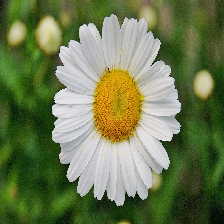

In [ ]:
# 이미지 불러오기
IMG_SIZE = 224
img_dir_path = '/content'
daisy_image_path = os.path.join(img_dir_path, 'daisy.jpg')

daisy_image = load_img(daisy_image_path, target_size=(IMG_SIZE, IMG_SIZE))
daisy_image

In [ ]:
# 모델에 넣기 쉽도록 배열 자료형으로 변환
daisy_image = img_to_array(daisy_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
daisy_image.shape

(1, 224, 224, 3)

In [ ]:
# 예측
prediction = model.predict(daisy_image)
prediction

1/1 [==============================] - 1s 919ms/step


array([[1.1278974e-01, 8.8802487e-02, 4.6404746e-01, 2.6803897e-04,
        3.3409226e-01]], dtype=float32)

In [ ]:
# 꽃이미지 예측
def show_and_predict_flower_image(dirpath, filename, class_names, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]

    # 가장 높은 확률을 가진 클래스의 인덱스를 찾고, 해당 꽃의 이름을 가져옵니다.
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = round(prediction[predicted_class_index] * 100, 2)

    print(f"이 이미지는 {confidence}% 확률로 {predicted_class_name} 입니다.")

1/1 [==============================] - 1s 889ms/step
이 이미지는 77.44% 확률로 tulips 입니다.


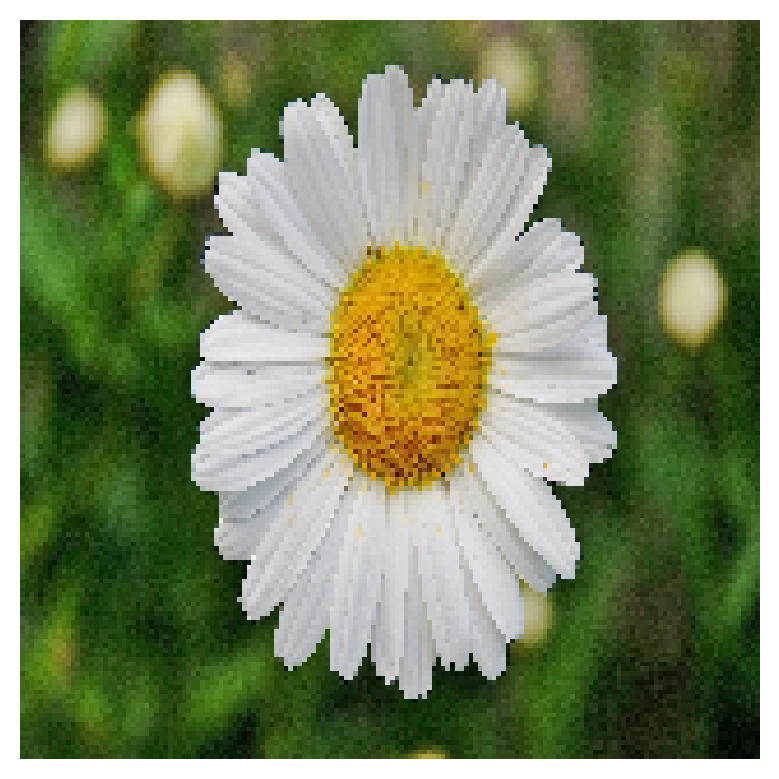

In [ ]:
# 꽃의 종류 목록
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# 이미지 디렉토리 경로
img_dir_path = '/content'

# daisy 이미지 확인
filename = 'daisy.jpg'

# 예측 함수 호출
show_and_predict_flower_image(img_dir_path, filename, class_names)

1/1 [==============================] - 0s 27ms/step
이 이미지는 62.04% 확률로 tulips 입니다.


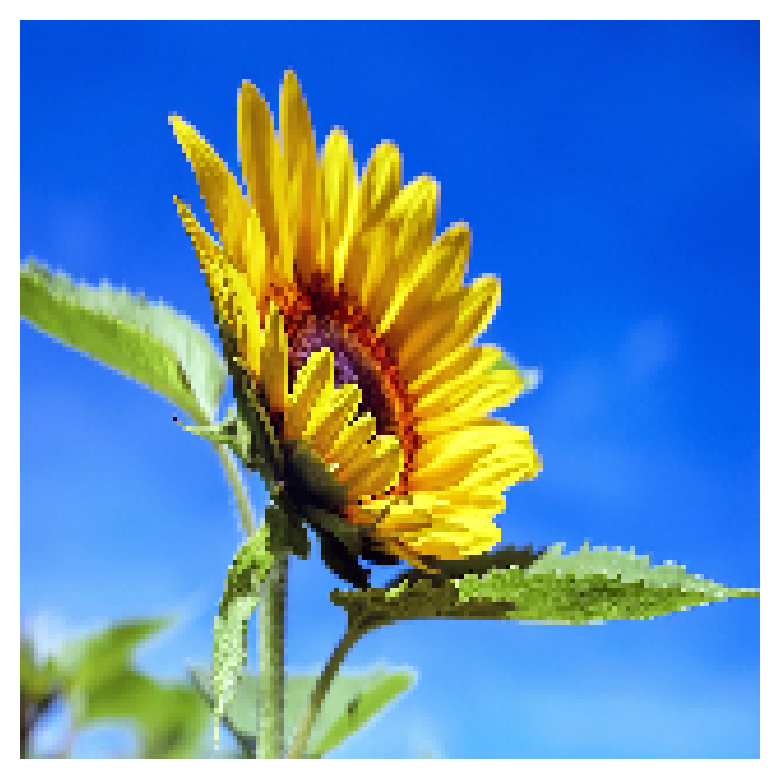

In [ ]:
# sunflowers 확인
filename = 'sunflowers.jpg'

# 예측 함수 호출
show_and_predict_flower_image(img_dir_path, filename, class_names)

1/1 [==============================] - 0s 25ms/step
이 이미지는 44.81% 확률로 daisy 입니다.


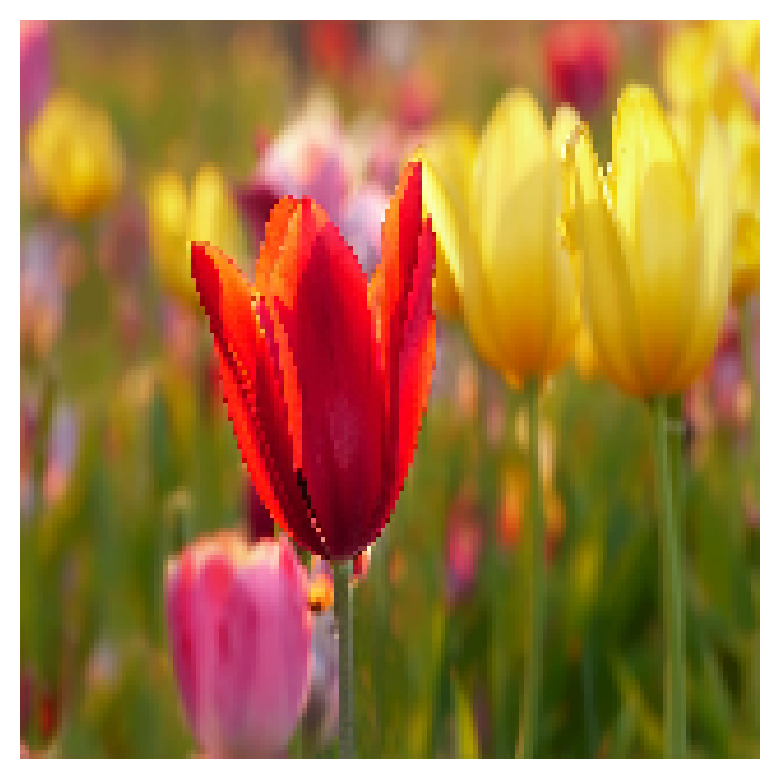

In [ ]:
# 튤립
filename = "tulips.jpg"

# 예측 함수 호출
show_and_predict_flower_image(img_dir_path, filename, class_names)

1/1 [==============================] - 0s 25ms/step
이 이미지는 97.0% 확률로 daisy 입니다.


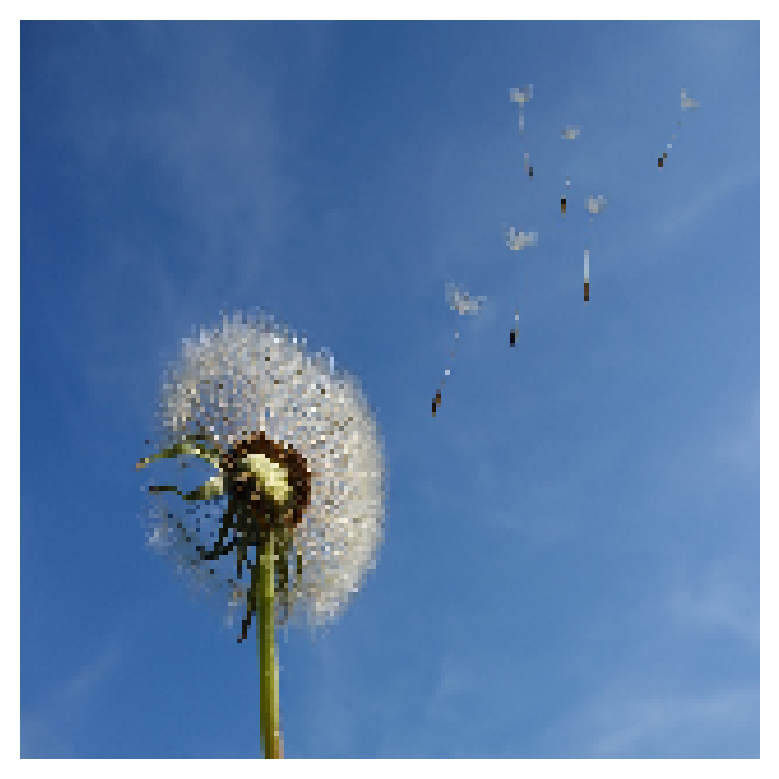

In [ ]:
# 단델리온
filename = "dandelion.jpg"

# 예측 함수 호출
show_and_predict_flower_image(img_dir_path, filename, class_names)

1/1 [==============================] - 0s 27ms/step
이 이미지는 99.99% 확률로 tulips 입니다.


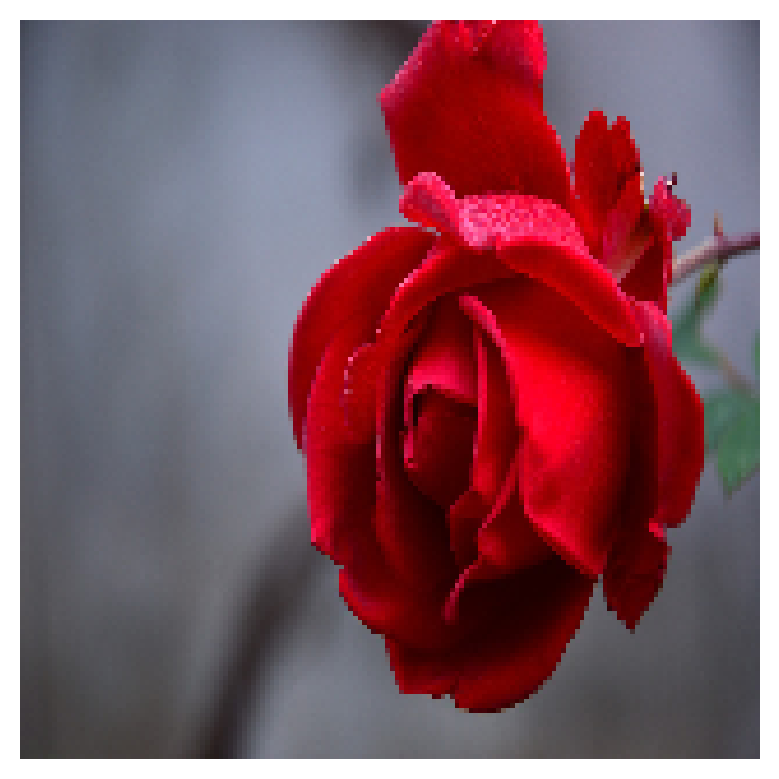

In [ ]:
# 장미
filename = "roses.jpg"

# 예측 함수 호출
show_and_predict_flower_image(img_dir_path, filename, class_names)

1/1 [==============================] - 0s 25ms/step
이 이미지는 45.36% 확률로 roses 입니다.


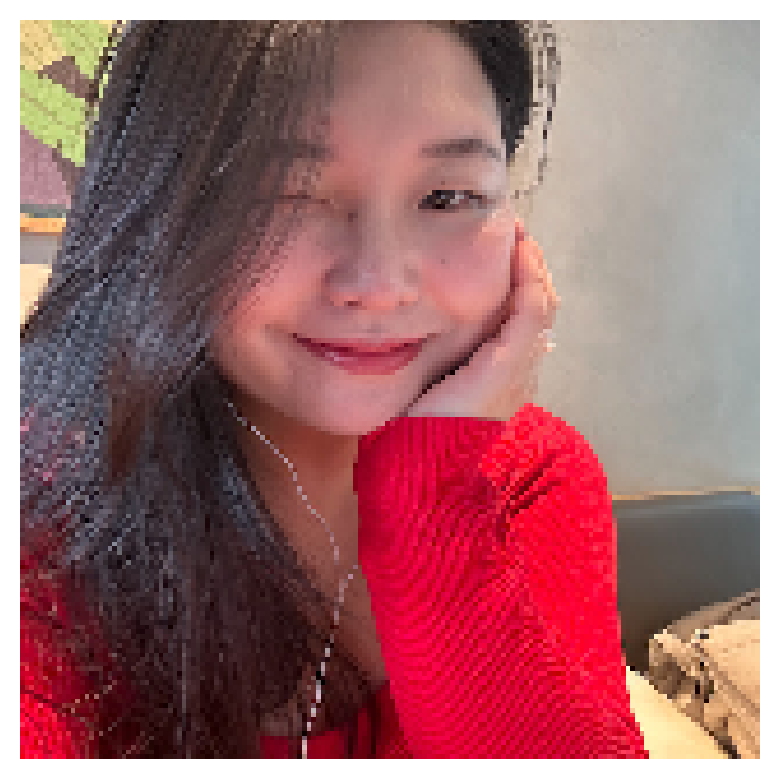

In [ ]:
# 나는 무슨 상 꽃이니? ㅋㅋㅋㅋㅋㅋㅋ
filename = "my_face.jpg"

# 예측 함수 호출
show_and_predict_flower_image(img_dir_path, filename, class_names)

# 회고
---

**Keep**: 얼리스탑을 활용해서 모델의 어큐러시를 높였다.

**Problem**: 딱히 큰 문제가 없었고, 시간이 오래걸려서 힘들었다.

**try**: 로컬 경로를 잘찾아서 데이터를 넣고 여러가지 시도를 해볼 수 있어서 재미있었다. 다음에도 이런 여러 시도를 해봐야겠다. 나만의 코드들이 점점 생기는 것 같아서 재미있다. 이 프로젝트를 활용해서 재미있는 다른 모델을 만들어 봐야겠다는 생각을 했다.

---

난 sunflowers이다 ㅎㅎ

